## Imports

In [11]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [12]:
def solve_2d_nonlinearconv_pure(u, v, nt, nx, ny, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        
        for i in range(1,nx-1):
            
            for j in range(1,ny-1):
                
                u[i,j] =u[i,j]-c*(dt/dx*u[i,j]*(u[i,j]-u[i-1,j])+dt/dy*v[i,j]*(u[i,j]-u[i,j-1]))
                
                v[i,j] =v[i,j]-c*(dt/dx*u[i,j]*(v[i,j]-v[i-1,j])+dt/dy*v[i,j]*(v[i,j]-v[i,j-1]))                                                   
        
    return 0

## Numba accelerator

In [13]:
@njit(fastmath=True)
def solve_2d_nonlinearconv_numba(u, v, nt, nx, ny, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        for i in range(1,nx):
            for j in range(1,ny):
                u[i,j]=u[i,j]-c*(dt/dx*u[i,j]*(u[i,j]-u[i-1,j])+dt/dy*v[i,j]*(u[i,j]-u[i,j-1]))
                
                v[i,j]=v[i,j]-c*(dt/dx*u[i,j]*(v[i,j]-v[i-1,j])+dt/dy*v[i,j]*(v[i,j]-v[i,j-1]))
    return 0

## Pyccel accelerator

In [14]:
@types('float[:,:]', 'float[:,:]', 'int', 'int', 'int','float','float','float', 'float')
def solve_2d_nonlinearconv_pyccel(u, v, nt, nx, ny, dt, dx, dy, c):

    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    ##set hat function I.C. : v(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1), int(.5 / dx):int(1 / dx + 1)] = 2
    #row, col = u.shape
    
    #fill the update of u and v
    for n in range(nt):
        for i in range(1,nx):
            for j in range(1,ny):
                u[i,j]=u[i,j]-c*(dt/dx*u[i,j]*(u[i,j]-u[i-1,j])+dt/dy*v[i,j]*(u[i,j]-u[i,j-1]))
                
                v[i,j]=v[i,j]-c*(dt/dx*u[i,j]*(v[i,j]-v[i-1,j])+dt/dy*v[i,j]*(v[i,j]-v[i,j-1]))

    return 0


## input

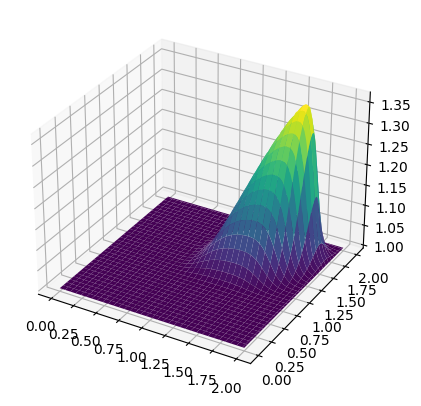

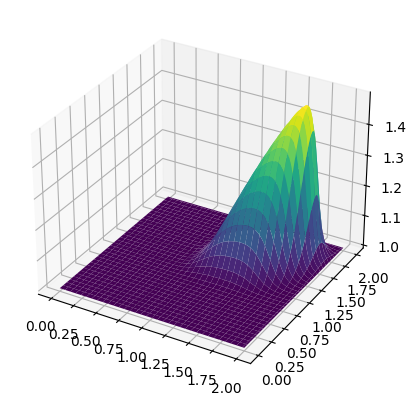

In [15]:
###variable declarations
nx = 101
ny = 101
nt = 80
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx)) ##create a 1xn vector of 1's
v = np.ones((ny, nx))
solve_2d_nonlinearconv_pure(u, v, nt, nx, ny, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)


fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, v, cmap=cm.viridis)

## Call Funtions

### Pure function

In [56]:
%timeit solve_2d_nonlinearconv_pure(u, v, nt, nx, ny, dt, dx, dy, c)

3.7 s ± 148 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [57]:
%timeit solve_2d_nonlinearconv_numba(u, v, nt, nx, ny, dt, dx, dy, c)

4.83 ms ± 41.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [58]:
solve_2d_nonlinearconv_f90 = epyccel(solve_2d_nonlinearconv_pyccel)

In [59]:
%timeit solve_2d_nonlinearconv_f90(u, v, nt, nx, ny, dt, dx, dy, c)

5 ms ± 70.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
